# Pitch & Roll prediction model

In [1]:
import tensorflow as tf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm
import json
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [2]:
print(torch.__version__)
print(pl.__version__)

1.6.0
1.5.10


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Num GPUs Available:  0
cpu


# Constants

In [4]:
num_epochs = 20
batchsize = 24
learning_rate = 0.0001
optimizer = "adam"
future_window_size = 12
past_window_size = 10
weight_decay = 0.001

encoder_latent_vector = 300
decoder_latent_vector = 300

N_EPISODES = 540
FRAMES_PER_EPISODE = 400
TRAIN_FOLDER = "3dmodel/test_4_episode_"
SEQUENCE_LENGTH = 50

TRAIN_SIZE = 0.8

# Load data from episodes

In [5]:
# view first episode 
filename = "../3dmodel/test_4_episode_1/labels_0.json"
data = []
labels = json.load(open(filename))
ep1 = pd.DataFrame(labels)
ep1 = ep1.transpose()
ep1.rename(columns = {0:'pitch', 1:'roll'}, inplace=True)
ep1

,pitch,roll
0,15.915869,2.358416
1,14.295925,1.700391
2,6.213590,1.611325
3,1.235337,6.175461
4,1.341678,3.695468
...,...,...
395,-0.204481,1.503337
396,1.074743,10.724272
397,13.373594,1.542949
398,11.193637,-0.848632


<AxesSubplot:>

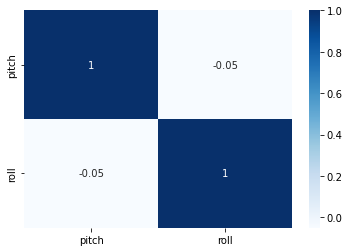

In [6]:
corr = ep1.corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [7]:
# load all data
pr = []
episodes = []
for ep in range(1, N_EPISODES+1):
    filename = "../3dmodel/test_4_episode_"+ str(ep) +"/labels_0.json"
    labels = json.load(open(filename))
    for i in labels:
        pr.append(labels[i])
        episodes.append(labels[i]+[ep, i])

In [8]:
p_r_df = pd.DataFrame(episodes)
p_r_df.rename(columns = {0:'pitch', 1:'roll', 2:'episode', 3:'position_within_episode'}, inplace=True)
p_r_df = p_r_df.astype({"pitch": float, "roll": float})
p_r_df

,pitch,roll,episode,position_within_episode
0,15.915869,2.358416,1,0
1,14.295925,1.700391,1,1
2,6.213590,1.611325,1,2
3,1.235337,6.175461,1,3
4,1.341678,3.695468,1,4
...,...,...,...,...
215995,0.428497,-0.663964,540,395
215996,0.485498,-1.376229,540,396
215997,-0.658033,-1.328761,540,397
215998,-1.322262,-1.650465,540,398


<AxesSubplot:>

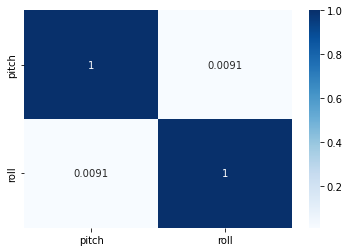

In [9]:
corr = p_r_df[['pitch','roll']].corr()
sns.heatmap(corr, cmap="Blues", annot=True)

In [10]:
df2 = p_r_df.copy()
df2["pr"] = list(zip(p_r_df["pitch"].round(2), p_r_df["roll"].round(2)))
df2.drop(columns=["pitch","roll"], axis=0, inplace=True)
df2 = df2[["pr","episode","position_within_episode"]]
rows = df2.groupby('episode')['pr'].apply(list)
df_stack = pd.DataFrame(rows)
df_stack = df_stack.reset_index()
df_stack

,episode,pr
0,1,"[(15.92, 2.36), (14.3, 1.7), (6.21, 1.61), (1...."
1,2,"[(15.98, 2.27), (9.86, 1.36), (6.11, 1.56), (1..."
2,3,"[(15.96, 2.07), (6.18, 0.12), (6.08, 1.68), (1..."
3,4,"[(7.7, 1.58), (8.48, 0.06), (3.16, 0.86), (1.0..."
4,5,"[(7.81, 1.49), (7.87, 0.18), (3.13, 0.91), (0...."
...,...,...
535,536,"[(27.03, -7.86), (19.12, -5.18), (12.65, -3.41..."
536,537,"[(18.02, -5.29), (18.95, -5.79), (10.58, -2.69..."
537,538,"[(21.82, -6.14), (14.1, -3.58), (9.7, -2.57), ..."
538,539,"[(21.23, -6.12), (16.44, -4.69), (10.11, -2.68..."


In [11]:
# Function to normalize pitch and roll angles
def norm_pr(x, min = -90.0, max = 90.0):
    return ((x - min) * 2) / (max - min) - 1

In [12]:
# normalize PR-values
p_r_df['pitch'] = p_r_df['pitch'].apply(lambda x : norm_pr(x))
p_r_df['roll'] = p_r_df['roll'].apply(lambda x : norm_pr(x))
p_r_df

,pitch,roll,episode,position_within_episode
0,0.176843,0.026205,1,0
1,0.158844,0.018893,1,1
2,0.069040,0.017904,1,2
3,0.013726,0.068616,1,3
4,0.014908,0.041061,1,4
...,...,...,...,...
215995,0.004761,-0.007377,540,395
215996,0.005394,-0.015291,540,396
215997,-0.007311,-0.014764,540,397
215998,-0.014692,-0.018338,540,398


# Create sequences with target value

In [13]:
# function to create sequences with one target column
def create_sequences(input_data: pd.DataFrame, target_column, sequence_length, input_columns = ["pitch", "roll"], episode_length = FRAMES_PER_EPISODE, n_episodes = N_EPISODES):
    sequences= []

    # make sequences per episode, one sequence can only hold data of one and the same episode!
    for n in tqdm(range(n_episodes)):

        for l in range(episode_length-SEQUENCE_LENGTH):
            
            i = l+(n*episode_length)

            sequence = input_data.iloc[i:i+sequence_length]

            target_position = i + sequence_length
            target = input_data.iloc[target_position][target_column]

            sequences.append((sequence, target))

    return sequences

In [14]:
try:
    with open('sequences.pkl', 'rb') as f:
        all_sequences = pickle.load(f)
except:
    all_sequences = create_sequences(p_r_df, "pitch", SEQUENCE_LENGTH)
    with open('sequences.pkl', 'wb') as f:
        pickle.dump(all_sequences, f)
all_sequences[0][0].shape

(50, 4)

In [15]:
# check sequence integrity
def test_sequences_integrity(sequences):
    fact = N_EPISODES*FRAMES_PER_EPISODE - N_EPISODES*SEQUENCE_LENGTH
    act = len(sequences)

    if(not fact == act):
        print("Length of sequences is: "+act+"\nShould be: "+fact)
        return False

    for seq in tqdm(range(len(sequences))):

        df = sequences[seq][0]
        if (len(df['episode'].unique()) !=1):
            print("seq: "+seq+" contains data from different episodes")
            return False
        
    print("All sequences are correct")
    return True

In [17]:
# !jupyter nbextension enable --py widgetsnbextension
test_sequences_integrity(all_sequences)

  0%|          | 0/189000 [00:00<?, ?it/s]

All sequences are correct


True

In [18]:
index = 349
print("Sequence for target value: ", all_sequences[index][1])
all_sequences[index][0].head(2).append(all_sequences[index][0].tail(2))

Sequence for target value:  0.05701720019222711


C:\Users\Lance De Waele\AppData\Local\Temp\ipykernel_16368\1807916976.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sequences[index][0].head(2).append(all_sequences[index][0].tail(2))


,pitch,roll,episode,position_within_episode
349,-0.027831,0.082243,1,349
350,0.110468,0.039379,1,350
397,0.148595,0.017144,1,397
398,0.124374,-0.009429,1,398


In [19]:
index = 350
print("Sequence for target value: ", all_sequences[index][1])
all_sequences[index][0].head(2).append(all_sequences[index][0].tail(2))

Sequence for target value:  0.2134670516065258


C:\Users\Lance De Waele\AppData\Local\Temp\ipykernel_16368\2494179134.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_sequences[index][0].head(2).append(all_sequences[index][0].tail(2))


,pitch,roll,episode,position_within_episode
400,0.177541,0.025201,2,0
401,0.109509,0.015121,2,1
448,0.184947,0.081514,2,48
449,0.172527,0.109872,2,49


In [20]:
# Grab random subsets from all sequences for training and test data (without overlapping data)
data_size = len(all_sequences)
data_indices = list(np.arange(0, data_size, 1))

# train indices are random sample from all data indices
random.seed(42)
train_size = int(TRAIN_SIZE * data_size)
train_indices = random.sample(data_indices, train_size)

# test indices are the difference of all data indices and train indices
test_indices = list(set(data_indices) - set(train_indices))

print((len(train_indices) + len(test_indices)) <= data_size)
print(len(train_indices), len(test_indices))
print(train_indices[:10])
print(test_indices[:10])

True
151200 37800
[167621, 29184, 6556, 72097, 64196, 58513, 36579, 26868, 177392, 142964]
[1, 131073, 4, 131077, 6, 131079, 11, 131088, 17, 131089]


In [21]:
# drop temporary episode and position_within_episode columns in all sequences
train_sequences = []
test_sequences = []

for idx in train_indices:
    seq = all_sequences[idx]
    seq[0].drop(columns=["episode", "position_within_episode"], axis=0, inplace = True)
    train_sequences.append(seq)

for idx in test_indices:
    seq = all_sequences[idx]
    seq[0].drop(columns=["episode", "position_within_episode"], axis=0, inplace = True)
    test_sequences.append(seq)

print((len(train_sequences) + len(test_sequences)) <= len(all_sequences))
len(train_sequences), train_sequences[0][0].shape, len(test_sequences), test_sequences[0][0].shape

True


(151200, (50, 2), 37800, (50, 2))

In [22]:
index = 0
print("Training sequence for target value: ", train_sequences[index][1])
train_sequences[index][0].head(2).append(train_sequences[index][0].tail(2))

Training sequence for target value:  0.22623322537496282


C:\Users\Lance De Waele\AppData\Local\Temp\ipykernel_16368\2523327542.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_sequences[index][0].head(2).append(train_sequences[index][0].tail(2))


,pitch,roll
191521,-0.143385,0.008034
191522,-0.030586,-0.100261
191569,0.037312,-0.005534
191570,0.130020,-0.031995


In [23]:
index = 1
print("Training sequence for target value: ", train_sequences[index][1])
train_sequences[index][0].head(2).append(train_sequences[index][0].tail(2))

Training sequence for target value:  -0.039163092816594136


C:\Users\Lance De Waele\AppData\Local\Temp\ipykernel_16368\1249250465.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_sequences[index][0].head(2).append(train_sequences[index][0].tail(2))


,pitch,roll
33334,0.033731,0.122046
33335,0.141326,0.081722
33382,-0.050703,-0.179941
33383,-0.037357,-0.218784


In [24]:
index = 0
print("Test sequence for target value: ", test_sequences[index][1])
test_sequences[index][0].head(2).append(test_sequences[index][0].tail(2))

Test sequence for target value:  0.2537734018821005


C:\Users\Lance De Waele\AppData\Local\Temp\ipykernel_16368\2060265415.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_sequences[index][0].head(2).append(test_sequences[index][0].tail(2))


,pitch,roll
1,0.158844,0.018893
2,0.069040,0.017904
49,0.181805,0.094970
50,0.164457,0.133329


In [25]:
index = 1
print("Test sequence for target value: ", test_sequences[index][1])
test_sequences[index][0].head(2).append(test_sequences[index][0].tail(2))

Test sequence for target value:  0.01842837450284951


C:\Users\Lance De Waele\AppData\Local\Temp\ipykernel_16368\1734708955.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_sequences[index][0].head(2).append(test_sequences[index][0].tail(2))


,pitch,roll
149773,0.013603,0.021756
149774,0.018201,0.033409
149821,0.037885,-0.014719
149822,0.042505,-0.003110


In [26]:
len(train_sequences), train_sequences[0][0].shape, len(test_sequences), test_sequences[0][0].shape

(151200, (50, 2), 37800, (50, 2))

## Pytorch Dataset

In [27]:
class PRDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, index):
        sequence, label = self.sequences[index]

        return dict(
            sequence = torch.Tensor(sequence.to_numpy()),
            label = torch.tensor(label).float()
        )

In [28]:
class PRDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batchsize = 8):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batchsize = batchsize

    def setup(self):
        self.train_dataset = PRDataset(self.train_sequences)
        self.test_dataset = PRDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size = self.batchsize,
            shuffle = False,
            num_workers=16,
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=16,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size = 1,
            shuffle = False,
            num_workers=16,
        )

In [33]:
NUM_EPOCHS = 8
BATCH_SIZE = 100

data_module = PRDataModule(train_sequences, test_sequences, BATCH_SIZE)
data_module.setup()

In [30]:
train_dataset = PRDataset(train_sequences)

In [32]:
for item in train_dataset:
    print(item["sequence"].shape)
    print(item["label"].shape)
    print(item["label"])
    break

torch.Size([50, 2])
torch.Size([])
tensor(0.2262)


## LSTM Model

In [80]:
class PRPredictionModel(nn.Module):
    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()

        self.n_hidden = n_hidden

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=0.2
        )

        self.regressor = nn.Linear(n_hidden, 1)

    def forward(self, x):
        self.lstm.flatten_parameters()
    
        _, (hidden, _) = self.lstm(x)
        out = hidden[-1]

        return self.regressor(out)

In [81]:
class PRPredictor(pl.LightningModule):
    def __init__(self, n_features: int): 
        super().__init__()

        self.model = PRPredictionModel(n_features)
        self.criterion = nn.MSELoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels.unsqueeze(dim=1))

        return loss, output
    
    def training_step(self, batch, batch_index):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_index):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_index):
        sequences = batch["sequence"]
        labels = batch["label"]

        loss, outputs = self(sequences, labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return optim.AdamW(self.parameters(), lr=0.0001)

In [82]:
model = PRPredictor(n_features=train_df.shape[1])

In [83]:
data_module_train_dataloader = data_module.train_dataloader()

In [84]:
"""
for item in data_module_train_dataloader:
    print(item["sequence"].shape)
    print(item["label"].shape)
    break
"""

'\nfor item in data_module_train_dataloader:\n    print(item["sequence"].shape)\n    print(item["label"].shape)\n    break\n'

In [85]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs


Reusing TensorBoard on port 6006 (pid 16948), started 9:13:41 ago. (Use '!kill 16948' to kill it.)

In [86]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="PR-prediction")

early_stopping_callback = EarlyStopping(monitor="val_loss", patience=2)

trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping_callback],
    max_epochs = NUM_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

C:\src\Anaconda\envs\ML env\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000002CECE30E8B0>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x000002CECE30E8B0>)`.
  rank_zero_deprecation(
C:\src\Anaconda\envs\ML env\lib\site-packages\pytorch_lightning\trainer\connectors\callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True

In [87]:
pl.__version__

'1.5.10'

In [88]:
trainer.fit(model, data_module)

C:\src\Anaconda\envs\ML env\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | PRPredictionModel | 200 K 
1 | criterion | MSELoss           | 0     
------------------------------------------------
200 K     Trainable params
0         Non-trainable params
200 K     Total params
0.803     Total estimated model params size (MB)


Validation sanity check:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
class LSTM_PR(nn.Module):
    def __init__(self, cuda, encoder_input_size, output_size, encoder_hidden_size=300, decoder_hidden_size=300): 
        super(LSTM_PR, self).__init__()
        self.cuda_p = cuda
        
        self.encoder_hidden_size = encoder_hidden_size
        self.decoder_hidden_size = decoder_hidden_size

         # (input size, hidden size, num_layers)
        self.encoder_lstm = nn.LSTM(encoder_input_size, encoder_hidden_size, batch_first=True)
        self.decoder_lstm = nn.LSTM(decoder_hidden_size, decoder_hidden_size, batch_first=True)

        # (in_features, out_features)
        self.decoder_fc_1 = nn.Linear(decoder_hidden_size, int(decoder_hidden_size/2))
        self.decoder_fc_2 = nn.Linear(int(decoder_hidden_size/2), output_size)
    
    def forward(self, pr, use_n_pr, predict_n_pr, encoder_hidden, decoder_hidden):
        PR  = [pr[i] for i in range(use_n_pr)]

        lstm_input_features = torch.cat(PR, 1).view(pr[0].size(0), 1, -1)

        encoder_output, encoder_hidden = self.LSTM_encoder(lstm_input_features,  encoder_hidden)
        decoder_output, decoder_hidden = self.LSTM_decoder(encoder_output, decoder_hidden)

        decoder_output = decoder_output.view(pr[0].size(0), predict_n_pr, -1)

        return decoder_output, encoder_hidden, decoder_hidden


